In [1]:

import pandas as pd 
import pandasql as ps
import numpy as np
import math as mh
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
from matplotlib.pyplot import figure
from scipy import stats
import matplotlib.pylab as plt
from IPython.core.pylabtools import figsize

figsize(20, 10)



In [2]:

figsize(20, 10)

# Collecting Data. 
## Hotjar 

We should give the proper date format before reading .csv 

We only need 2 inputs. Date and Score. 

## Date: it shoud be the type of 'yyyy-mm-dd'.

## Score: the value the customer is reporting from 0 to 10

In [3]:
df = pd.read_csv('NPS-2018-2019.csv', sep = ';')
print(df.head())


q1 = """SELECT date(Date) as dates,score FROM df"""

#print(ps.sqldf(q1, locals()))
df_n = ps.sqldf(q1, locals())
df_n.head()


         Date  score
0  2018-10-02      9
1  2018-10-02      3
2  2018-10-02      8
3  2018-10-02     10
4  2018-10-02      7


,dates,score
0,2018-10-02,9
1,2018-10-02,3
2,2018-10-02,8
3,2018-10-02,10
4,2018-10-02,7


In [4]:
df = pd.read_csv('NPS-2018-2019.csv', sep = ';')
print(df.head())


q1 = """SELECT date(Date) as dates,score FROM df"""

#print(ps.sqldf(q1, locals()))
df_n = ps.sqldf(q1, locals())
df_n.head()

df_n['dayofyear'] = pd.to_datetime(df_n['dates']).dt.dayofyear.astype(int)
df_n['dayofweek'] = pd.to_datetime(df_n['dates']).dt.dayofweek.astype(int)
df_n['week_'] = pd.to_datetime(df_n['dates']).dt.week.astype(int)
df_n['year_'] = pd.to_datetime(df_n['dates']).dt.year.astype(int)
df_n['month_'] = pd.to_datetime(df_n['dates']).dt.month.astype(int)
df_n.head()

         Date  score
0  2018-10-02      9
1  2018-10-02      3
2  2018-10-02      8
3  2018-10-02     10
4  2018-10-02      7


,dates,score,dayofyear,dayofweek,week_,year_,month_
0,2018-10-02,9,275,1,40,2018,10
1,2018-10-02,3,275,1,40,2018,10
2,2018-10-02,8,275,1,40,2018,10
3,2018-10-02,10,275,1,40,2018,10
4,2018-10-02,7,275,1,40,2018,10


## Daily

We have a huge volatility. That's why the daily non coocked time series is useless

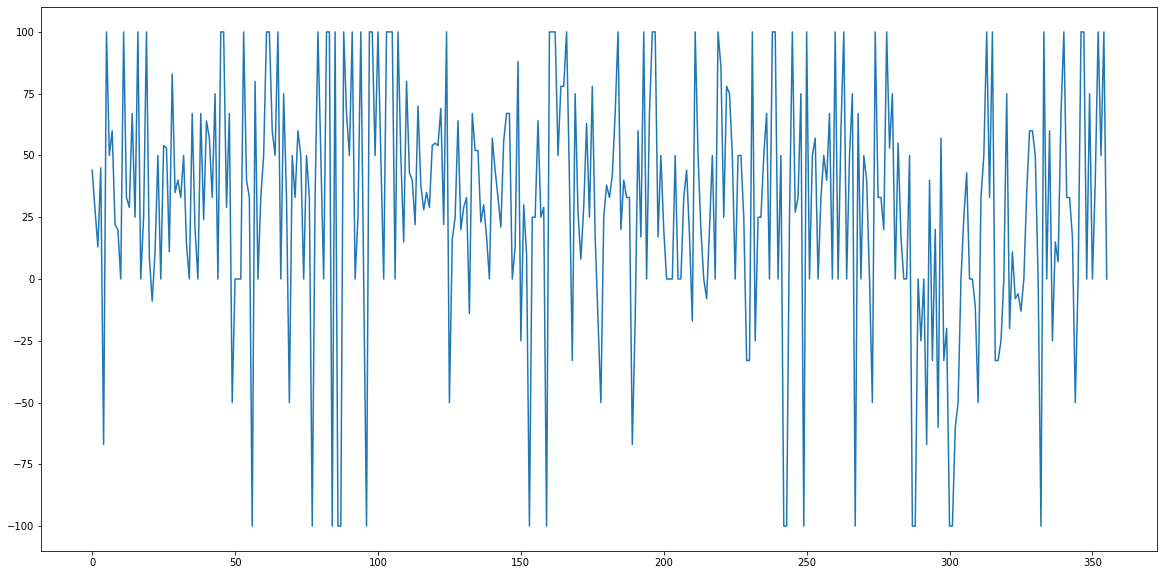

In [5]:

q2 = """SELECT * , ROUND(100.0*(promoters-detractors)/(promoters+detractors+neutrals)) as nps
        FROM (
        SELECT dates,month_,week_, year_ , year_||dayofyear as dayofyear,
        SUM(CASE WHEN score in (9,10) then 1 else 0 end) as promoters,
        SUM(CASE WHEN score in (8,7) then 1 else 0 end) as neutrals,
        SUM(CASE WHEN score < 7 and score >= 0 then 1 else 0 end) as detractors
        FROM df_n GROUP BY 1,2,3,4,5 ) a"""

#print(ps.sqldf(q1, locals()))
df_day = ps.sqldf(q2, locals())
df_day.tail()
plt.plot(df_day.nps)


## Weekly

We are more confident with the predictibility of the time series in week aggregates, but we are only able to report the value next week.

    month_  week_  year_  promoters  neutrals  detractors         nps
60      12     48   2018          0         0           1 -100.000000
61      12     49   2018         11         4           1   62.500000
62      12     50   2018         14         5           4   43.478261
63      12     51   2018         15         3           4   50.000000
64      12     52   2018          5         3           2   30.000000


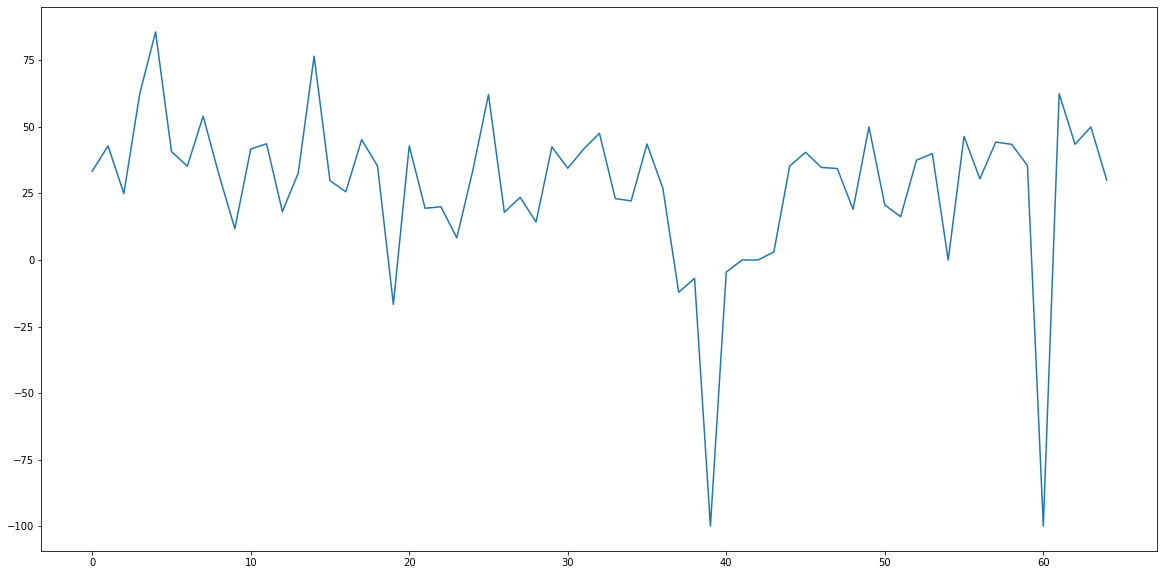

In [6]:
q2_ = """SELECT * , 100.0*(promoters-detractors)/(promoters+detractors+neutrals) as nps
        FROM (
        SELECT month_,week_, year_ , 
        SUM(CASE WHEN score in (9,10) then 1 else 0 end) as promoters,
        SUM(CASE WHEN score in (8,7) then 1 else 0 end) as neutrals,
        SUM(CASE WHEN score < 7 and score >= 0 then 1 else 0 end) as detractors
        FROM df_n GROUP BY 1,2,3 ) a"""

#print(ps.sqldf(q1, locals()))
df__day = ps.sqldf(q2_, locals())
print(df__day.tail())
plt.plot(df__day.nps)


## All Cumulative

It brings a lot of confidence with the prtedictibility, but it is hard to notice when the metric is on critical ranges. The smoothing effect of the whole aggregation makes hard to notice when something is going wrong

,dates,month_,week_,year_,dayofyear,promoters,detractors,neutrals,cum_promoters,cum_detractors,cum_neutrals,nps,cum_nps
351,2019-10-24,10,43,2019,2019297,3,1,1,1420,590,533,40.0,32.638616
352,2019-10-25,10,43,2019,2019298,2,0,0,1422,590,533,100.0,32.691552
353,2019-10-26,10,43,2019,2019299,1,0,1,1423,590,534,50.0,32.705143
354,2019-10-27,10,43,2019,2019300,1,0,0,1424,590,534,100.0,32.731554
355,2019-10-28,10,44,2019,2019301,2,2,1,1426,592,535,0.0,32.667450


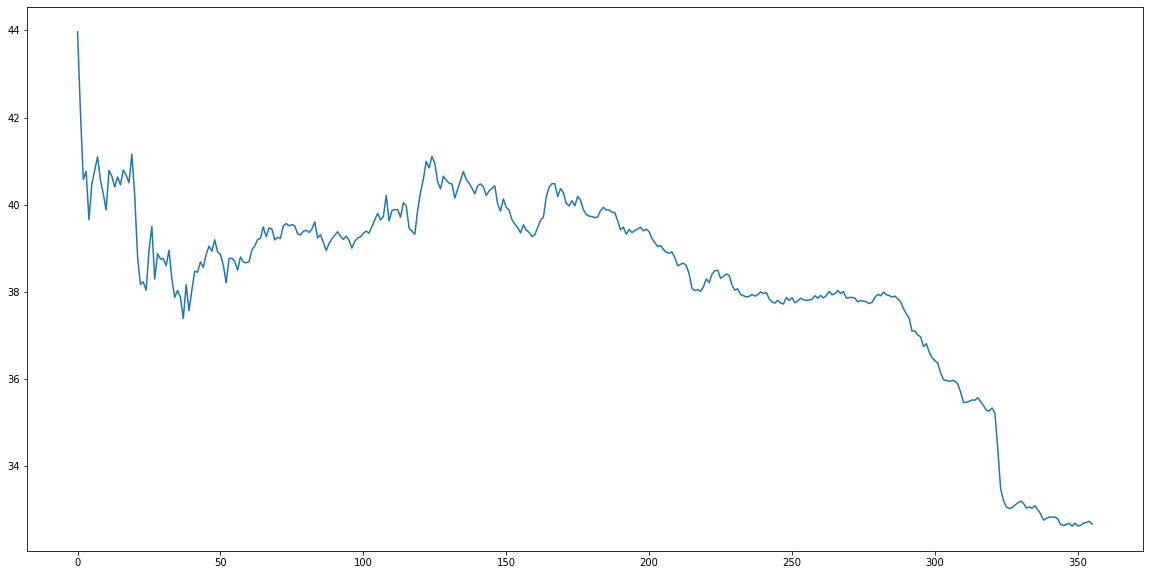

In [7]:

q221 = """SELECT * , 
                100.0*(promoters-detractors)/(promoters+detractors+neutrals) as nps,  
                100.0*(cum_promoters-cum_detractors)/(cum_promoters+cum_detractors+cum_neutrals) as cum_nps
        FROM (
        SELECT a.dates,a.month_,a.week_, a.year_ ,a.dayofyear,  a.promoters, a.detractors , a.neutrals, 
        sum(b.promoters) as cum_promoters,sum(b.detractors) as cum_detractors, sum(b.neutrals) cum_neutrals
        from df_day a inner join df_day b on a.dates >= b.dates 
        group by 1,2,3,4,5,6,7,8
        order by 1) a"""

#print(ps.sqldf(q1, locals()))
df2_cumday = ps.sqldf(q221, locals())
plt.plot(df2_cumday.cum_nps)
df2_cumday.tail()


## Monthly cummulative

It is the current way to report that metric. As we can see, it's a Lèvy -Îto process with jumps. The volatility is almost bounded but  the beginnig of the month. 

Volatility: 7.227


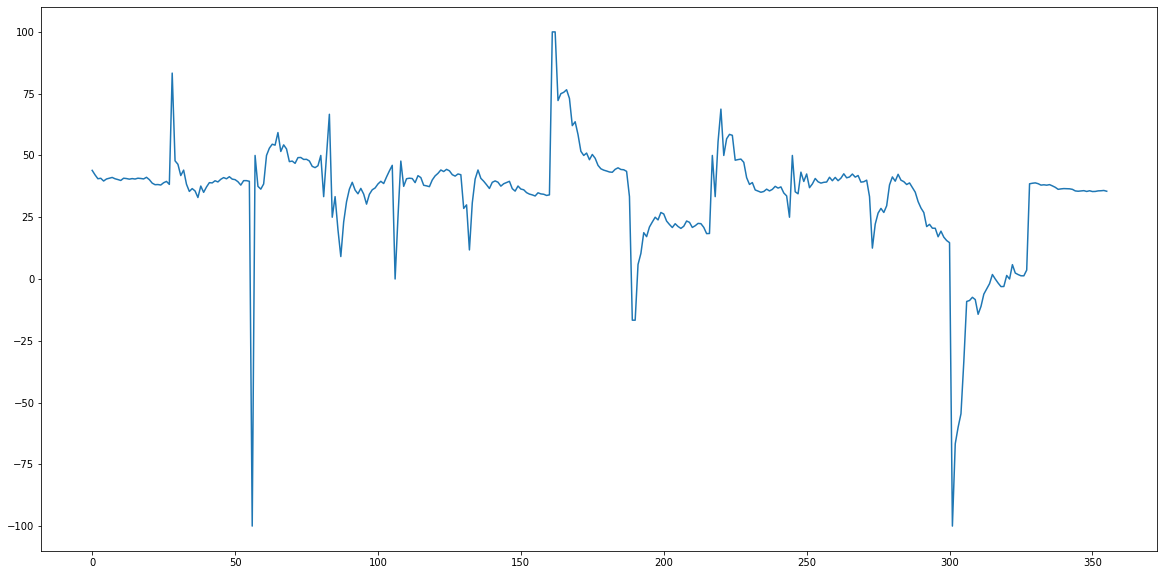

In [8]:

q211 = """SELECT * , 
                ROUND(100.0*(promoters-detractors)/(promoters+detractors+neutrals)) as nps,  
                100.0*(cum_promoters-cum_detractors)/(cum_promoters+cum_detractors+cum_neutrals) as cum_nps
        FROM (
        SELECT a.dates,a.month_,a.week_, a.year_ , a.dayofyear,  a.promoters, a.detractors , a.neutrals,
        sum(b.promoters) as cum_promoters,sum(b.detractors) as cum_detractors, sum(b.neutrals) cum_neutrals
        from df_day a inner join df_day b on a.dates >= b.dates and b.month_ = a.month_
        group by 1,2,3,4,5,6,7,8
        order by 1) a"""

#print(ps.sqldf(q1, locals()))
df_cumday1 = ps.sqldf(q211, locals())
plt.plot(df_cumday1.cum_nps)
vol = df_cumday1.cum_nps.rolling(7).std().mean()
print('Volatility: %.3f' %vol)


## PO's anxiety

the result of the PO's electrocardiogram

Volatility: 7.227


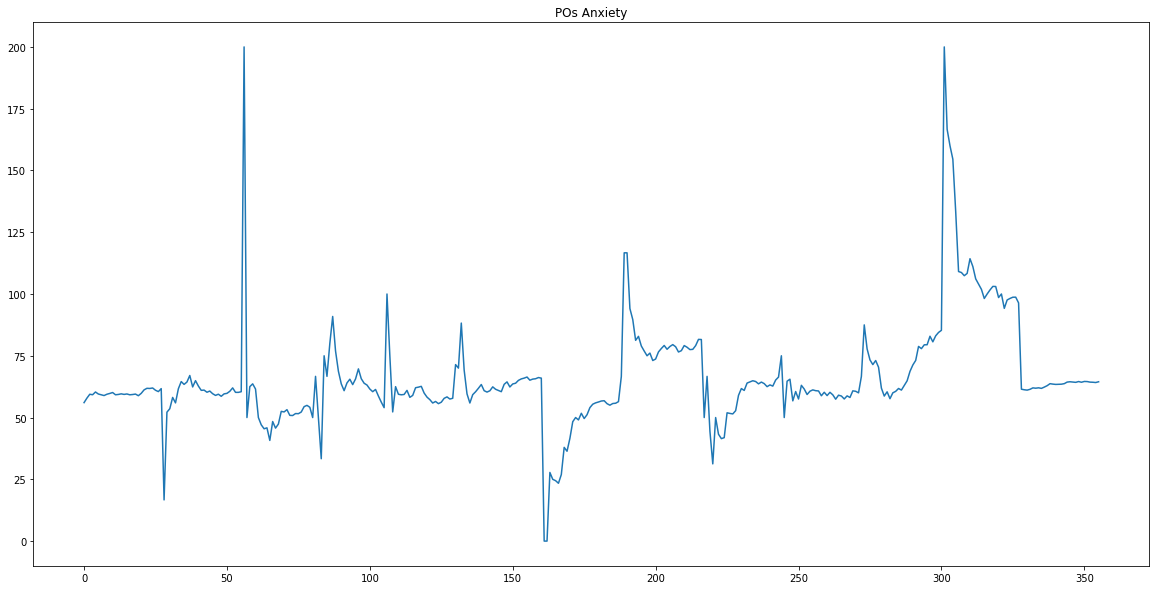

In [9]:
plt.plot(100 - df_cumday1.cum_nps)
plt.title('POs Anxiety')
vol = df_cumday1.cum_nps.rolling(7).std().mean()
print('Volatility: %.3f' %vol)


# New NPS (30 days rolling window)

Volatility: 1.942


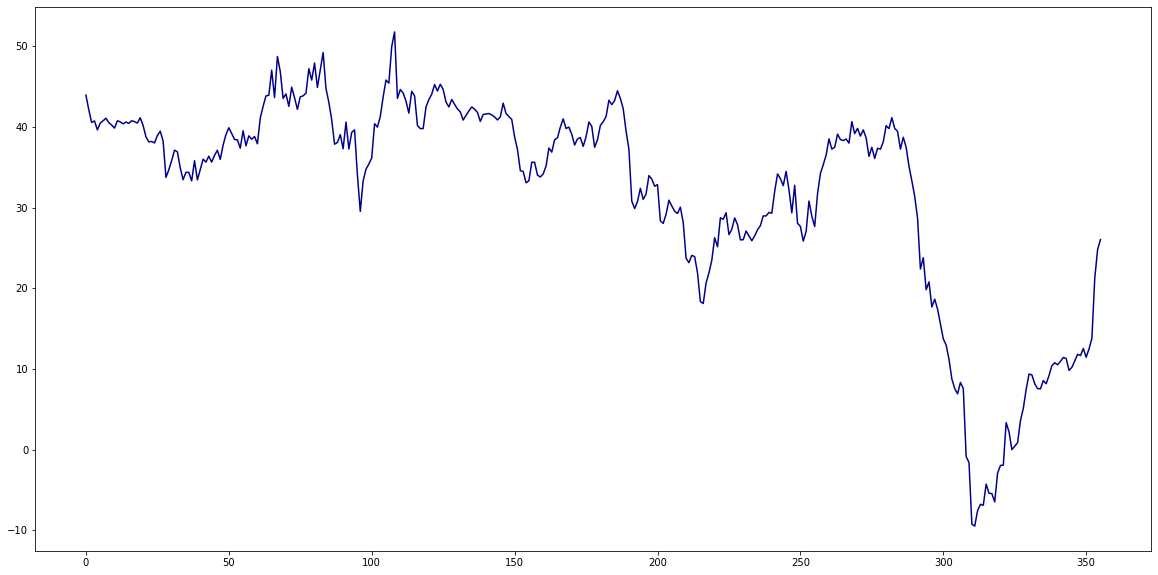

In [10]:

q21 = """SELECT * , 
                100.0*(promoters-detractors)/(promoters+detractors+neutrals) as nps,  
                100.0*(cum_promoters-cum_detractors)/(cum_promoters+cum_detractors+cum_neutrals) as cum_nps
        FROM (
        SELECT a.dates,a.month_,a.week_, a.year_ , a.dayofyear,  a.promoters, a.detractors , a.neutrals,
        sum(b.promoters) as cum_promoters,sum(b.detractors) as cum_detractors, sum(b.neutrals) cum_neutrals
        from df_day a inner join df_day b on a.dates >= b.dates and b.dates > datetime(a.dates, '-30 days')
        group by 1,2,3,4,5,6,7,8
        order by 1) a"""

#print(ps.sqldf(q1, locals()))

df_cumday = ps.sqldf(q21, locals())
plt.plot(df_cumday.cum_nps, c = 'darkblue') 

vol = df_cumday.cum_nps.rolling(7).std().mean()
print('Volatility: %.3f' %vol)


In [11]:
df_day.tail()


,dates,month_,week_,year_,dayofyear,promoters,neutrals,detractors,nps
351,2019-10-24,10,43,2019,2019297,3,1,1,40.0
352,2019-10-25,10,43,2019,2019298,2,0,0,100.0
353,2019-10-26,10,43,2019,2019299,1,1,0,50.0
354,2019-10-27,10,43,2019,2019300,1,0,0,100.0
355,2019-10-28,10,44,2019,2019301,2,1,2,0.0


## Volatility Comparison

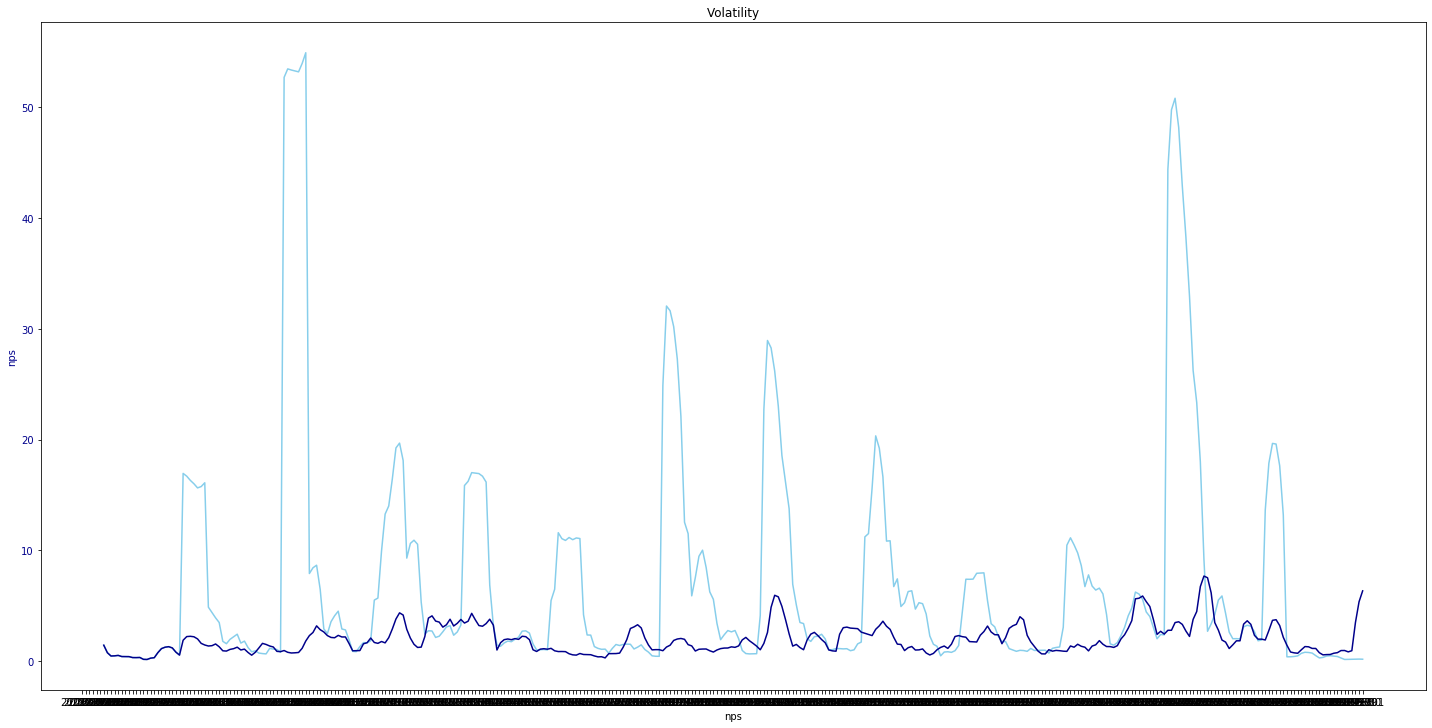

In [12]:
import numpy as np
import matplotlib.pyplot as plt

t = df_cumday1.dayofyear
data1 = df_cumday1.cum_nps.rolling(7).std()
data1_ = df_cumday.cum_nps.rolling(7).std()


fig, ax1 = plt.subplots()

color = 'darkblue'
ax1.set_xlabel('nps')
ax1.set_ylabel('nps', color=color)
ax1.plot(t, data1, color='skyblue', alpha=1)
ax1.plot(t, data1_, color='darkblue', alpha=1)
ax1.tick_params(axis='y', labelcolor=color)



fig.tight_layout()  # otherwise the right y-label is slightly clipped
plt.title('Volatility')
plt.show()


## NPS Comparison

INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.


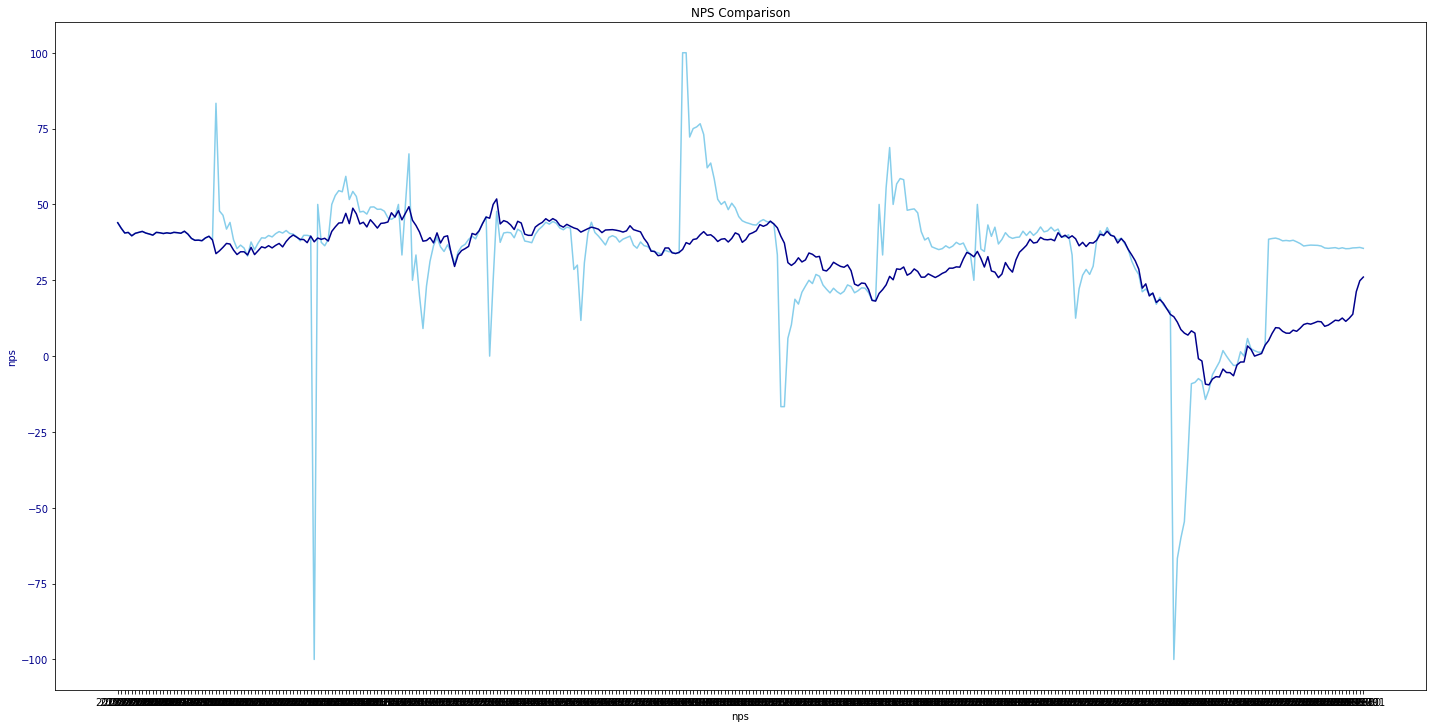

In [36]:
import numpy as np
import matplotlib.pyplot as plt

t = df_cumday1.dayofyear
data1 = df_cumday1.cum_nps
data1_ = df_cumday.cum_nps


fig, ax1 = plt.subplots()

color = 'darkblue'
ax1.set_xlabel('nps')
ax1.set_ylabel('nps', color=color)
ax1.plot(t, data1, color='skyblue', alpha=1)
ax1.plot(t, data1_, color='darkblue', alpha=1)
ax1.tick_params(axis='y', labelcolor=color)


fig.tight_layout()  # otherwise the right y-label is slightly clipped
plt.title('NPS Comparison')
plt.show()


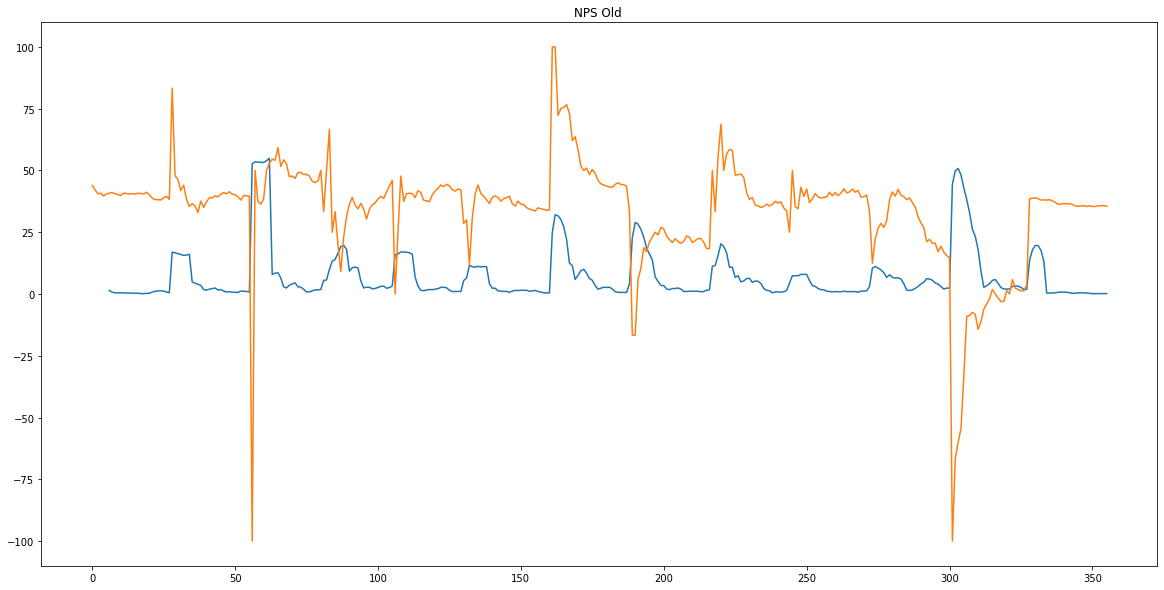

In [14]:
plt.title('NPS Old ')
plt.plot(df_cumday1.cum_nps.rolling(7).std())
plt.plot(df_cumday1.cum_nps)




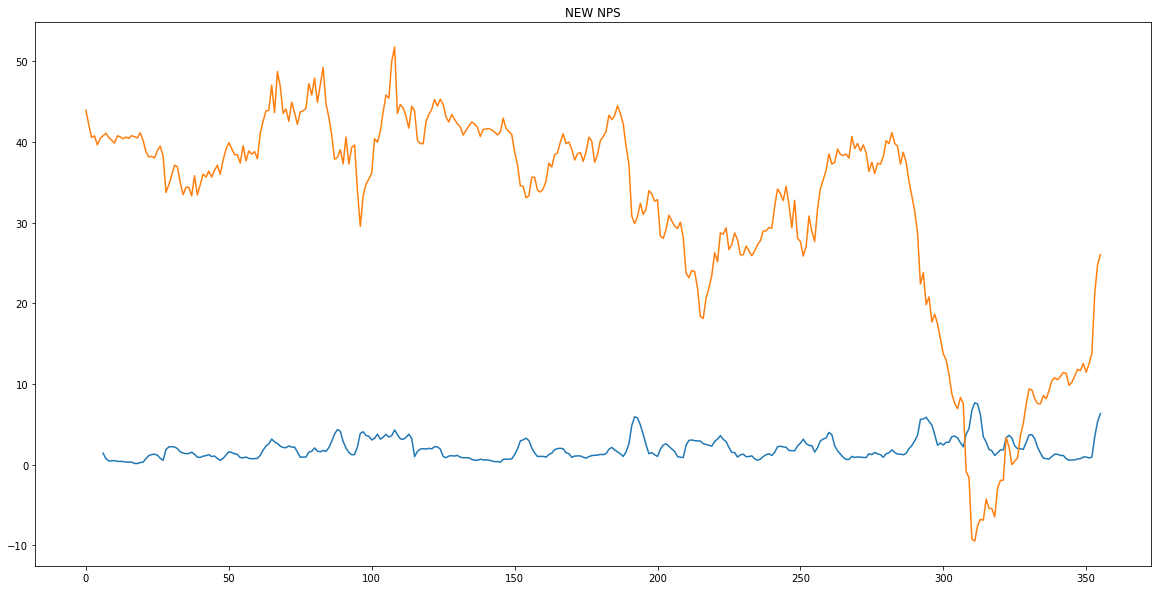

In [15]:
plt.title('NEW NPS')
plt.plot(df_cumday.cum_nps.rolling(7).std())
plt.plot(df_cumday.cum_nps)



-2.1276912496995046


/Users/xavier.gamito/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
/Users/xavier.gamito/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


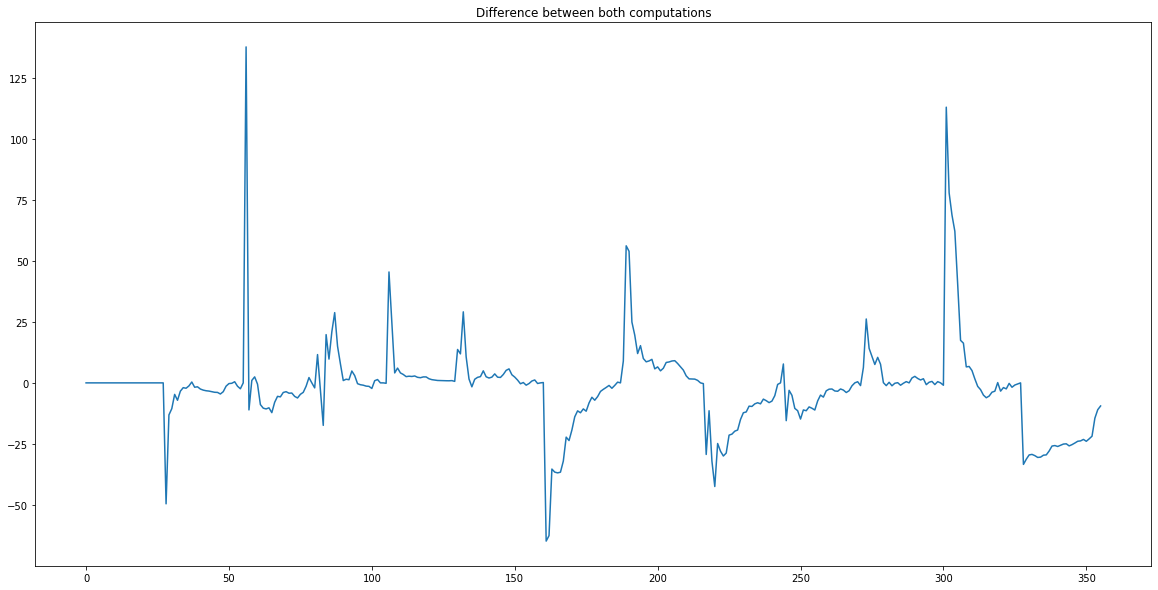

In [38]:
df_comp = df_cumday[['dates', 'cum_nps']]
df_comp['cum_nps_old'] = df_cumday1['cum_nps']
df_comp['diff'] = df_comp.cum_nps - df_comp.cum_nps_old
diff = df_comp['diff']



print(diff.mean())
plt.title('Difference between both computations')
plt.plot(diff)




## Deep Dive on users

In [16]:

# Create some mock data
t = df_cumday.dayofyear
data1 = df_cumday.cum_nps
data2 = df_cumday.cum_nps.rolling(7).std()


color = 'darkblue'
ax1.set_xlabel('nps')
ax1.set_ylabel('nps', color=color)
ax1.plot(t, data1, color='darkblue', alpha=1)
ax1.tick_params(axis='y', labelcolor=color)

ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

color = 'tab:orange'
ax2.plot(t, data2, color=color)


ax2.tick_params(axis='y', labelcolor='orange')


fig.tight_layout()  # otherwise the right y-label is slightly clipped
plt.show()


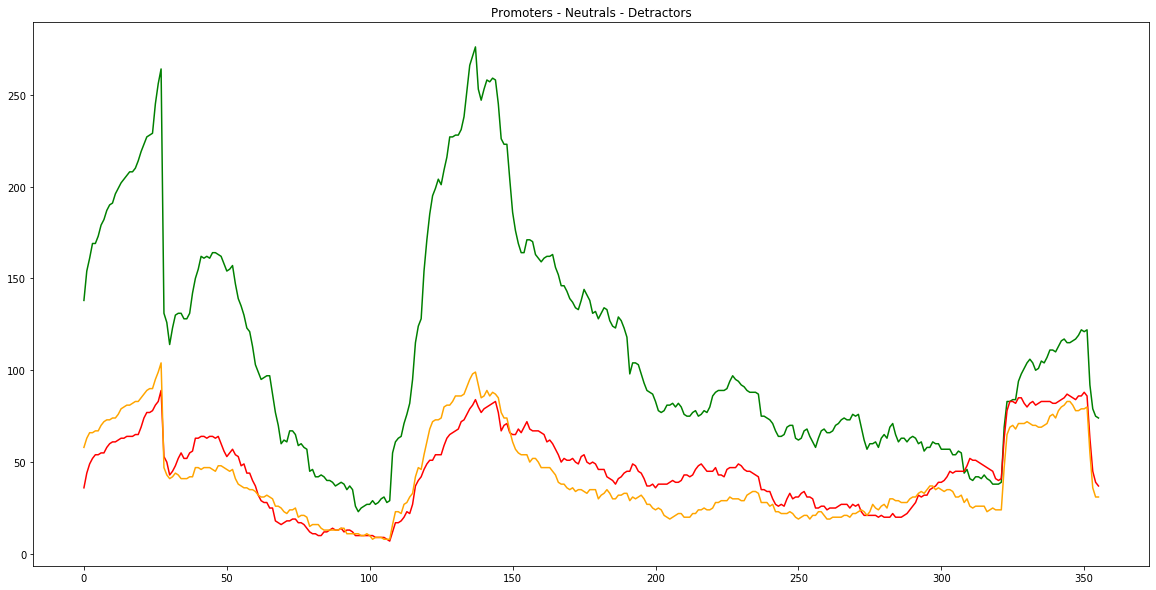

In [17]:
plt.title('Promoters - Neutrals - Detractors')
plt.plot(df_cumday.cum_promoters, c = 'green') 
plt.plot(df_cumday.cum_detractors, c='red')
plt.plot(df_cumday.cum_neutrals,  c='orange')

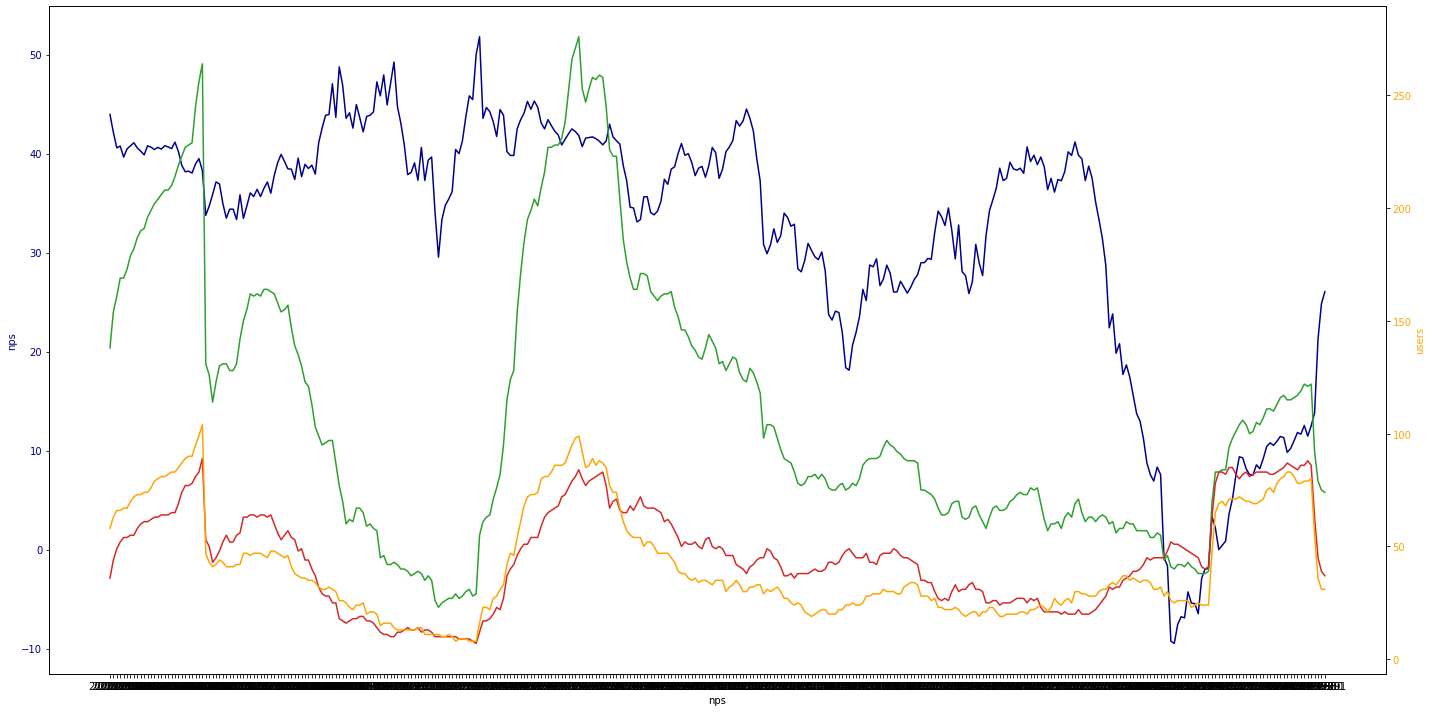

In [18]:
import numpy as np
import matplotlib.pyplot as plt

# Create some mock data
t = df_cumday.dayofyear
data1 = df_cumday.cum_nps
data2 = df_cumday.cum_promoters
data3 = df_cumday.cum_detractors
data4 = df_cumday.cum_neutrals

fig, ax1 = plt.subplots()

color = 'darkblue'
ax1.set_xlabel('nps')
ax1.set_ylabel('nps', color=color)
ax1.plot(t, data1, color='darkblue', alpha=1)
ax1.tick_params(axis='y', labelcolor=color)

ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

color = 'tab:green'
ax2.plot(t, data2, color=color)
color = 'tab:red'
ax2.set_ylabel('users', color='orange')  # we already handled the x-label with ax1
ax2.plot(t, data3, color=color)
ax2.plot(t, data4, color='orange')

ax2.tick_params(axis='y', labelcolor='orange')


fig.tight_layout()  # otherwise the right y-label is slightly clipped
plt.show()


# Saturation coefficient
## Usefull metric oriented to PRO teams (Client)

We noticed in the PRO teams, we have few users to impact with NPS. If they are excluded once they answer, we tend to consume the promoters. 

aprox: 6.500 customers


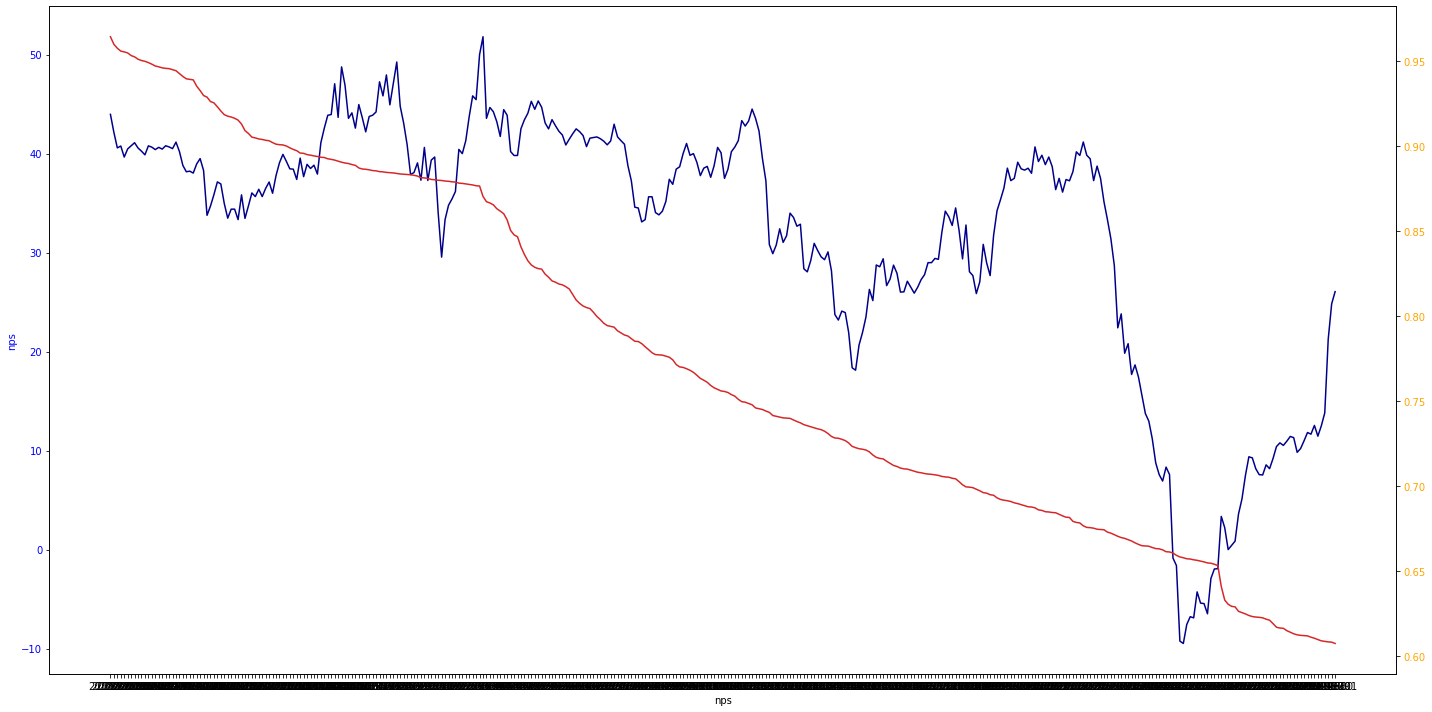

In [19]:
print('aprox: 6.500 customers')
cust = 6500.0

# Create some mock data
t = df_cumday.dayofyear
data1 = df_cumday.cum_nps

fig, ax1 = plt.subplots()

color = 'blue'
ax1.set_xlabel('nps')
ax1.set_ylabel('nps', color=color)
ax1.plot(t, data1, color='darkblue', alpha=1)
ax1.tick_params(axis='y', labelcolor=color)

ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

color = 'tab:red'
ax2.plot(t, 1-(df2_cumday.cum_promoters+df2_cumday.cum_detractors+df2_cumday.cum_neutrals)/cust, color=color)


ax2.tick_params(axis='y', labelcolor='orange')


fig.tight_layout()  # otherwise the right y-label is slightly clipped
plt.show()

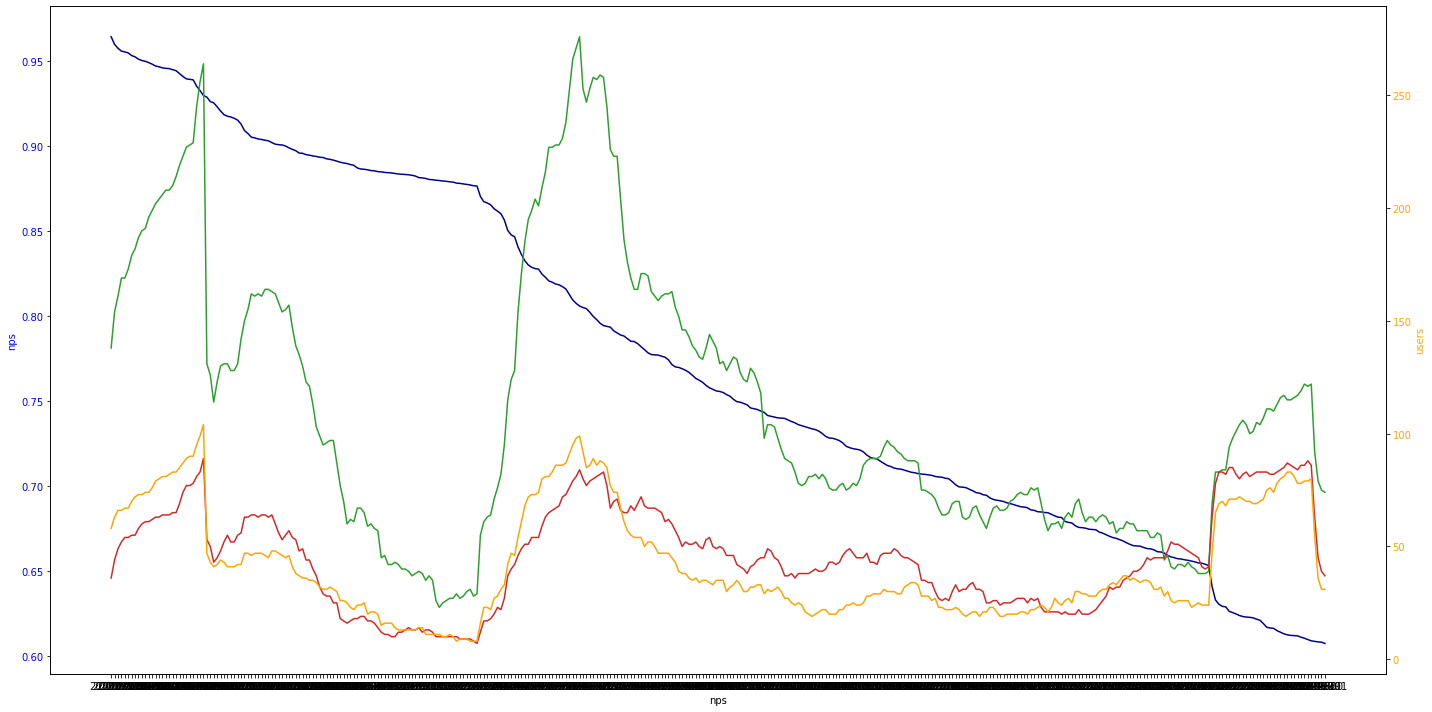

In [20]:
# Create some mock data
t = df_cumday.dayofyear
data1 = 1-(df2_cumday.cum_promoters+df2_cumday.cum_detractors+df2_cumday.cum_neutrals)/cust
data2 = df_cumday.cum_promoters
data3 = df_cumday.cum_detractors
data4 = df_cumday.cum_neutrals

fig, ax1 = plt.subplots()

color = 'blue'
ax1.set_xlabel('nps')
ax1.set_ylabel('nps', color=color)
ax1.plot(t, data1, color='darkblue', alpha=1)
ax1.tick_params(axis='y', labelcolor=color)

ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

color = 'tab:green'
ax2.plot(t, data2, color=color)
color = 'tab:red'
ax2.set_ylabel('users', color='orange')  # we already handled the x-label with ax1
ax2.plot(t, data3, color=color)
ax2.plot(t, data4, color='orange')

ax2.tick_params(axis='y', labelcolor='orange')


fig.tight_layout()  # otherwise the right y-label is slightly clipped
plt.show()

In [21]:
print(df_cumday.iloc[df_cumday.cum_nps.idxmin(axis=0, skipna=True)])


dates             2019-09-12
month_                     9
week_                     37
year_                   2019
dayofyear            2019255
promoters                  2
detractors                 1
neutrals                   0
cum_promoters             40
cum_detractors            51
cum_neutrals              25
nps                  33.3333
cum_nps             -9.48276
Name: 311, dtype: object


# Predictibility

ERROR:fbprophet:Importing plotly failed. Interactive plots will not work.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
/Users/xavier.gamito/anaconda3/lib/python3.7/site-packages/pystan/misc.py:399: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  elif np.issubdtype(np.asarray(v).dtype, float):


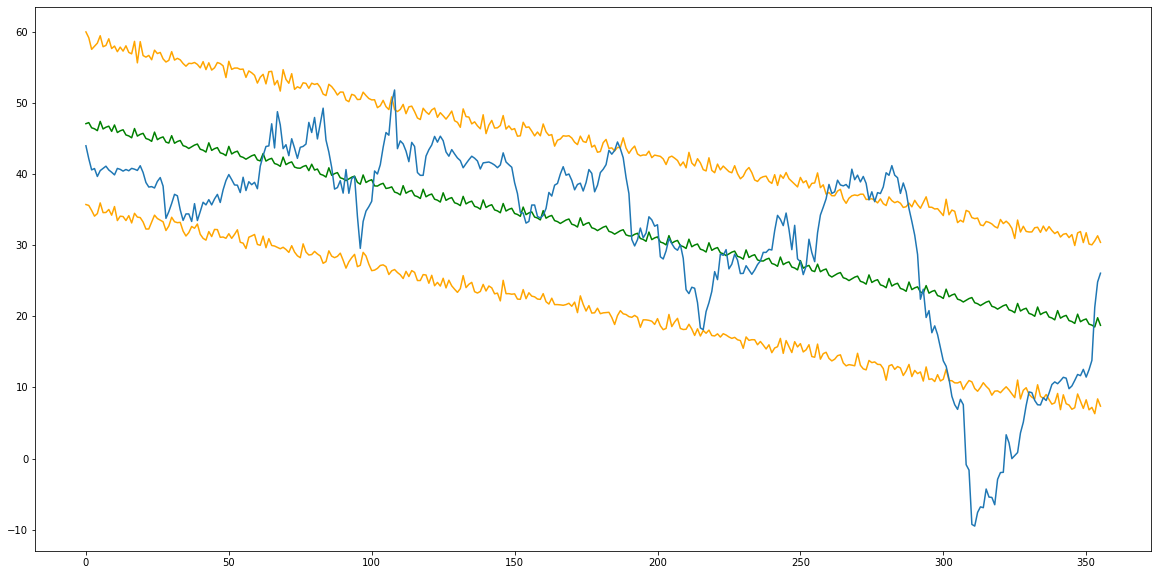

In [22]:

import pandas as pd
import numpy as np
from fbprophet import Prophet
import holidays


_arg3 = 29
period = _arg3+1
df = pd.DataFrame(
    {'ds': df_cumday.dates,
     'y': df_cumday.cum_nps
    })
#print(df.ds)
m = Prophet()#holidays = holidays)
m = Prophet(changepoints=['2019-09-25'])
#m.add_country_holidays(country_name='ES')
df = df[:-period]
m.fit(df);
future = m.make_future_dataframe(periods=period)
forecast = m.predict(future)
plt.plot(forecast['yhat'], c = 'green') 
plt.plot(forecast['yhat_lower'], c = 'orange') 
plt.plot(forecast['yhat_upper'], c = 'orange') 
plt.plot(df_cumday.cum_nps)


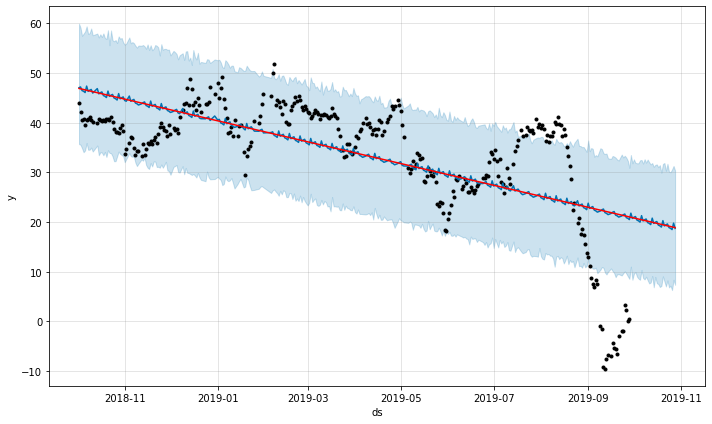

In [23]:
from fbprophet.plot import add_changepoints_to_plot
fig = m.plot(forecast)
a = add_changepoints_to_plot(fig.gca(), m, forecast)


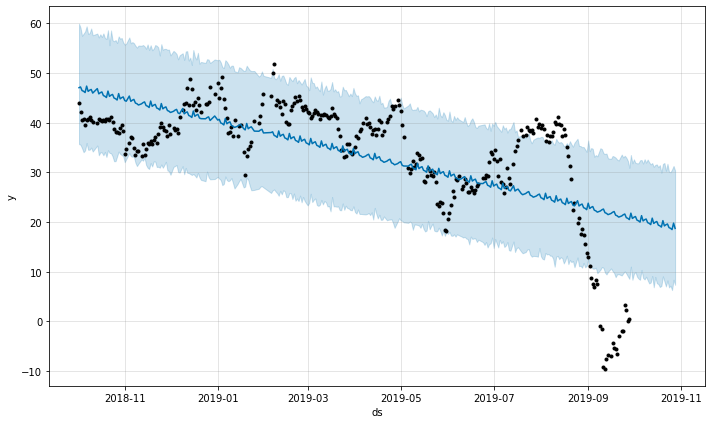

In [24]:
fig1 = m.plot(forecast)


# Predictions using FbProphet. 
## zooming on trends changes, forecasting and thresholds

Here we are about to finish our analysis. Since we can control volatility, we can apply many forecasting methods in order to understand the upcoming behaviour from our NPS metric

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
/Users/xavier.gamito/anaconda3/lib/python3.7/site-packages/pystan/misc.py:399: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  elif np.issubdtype(np.asarray(v).dtype, float):


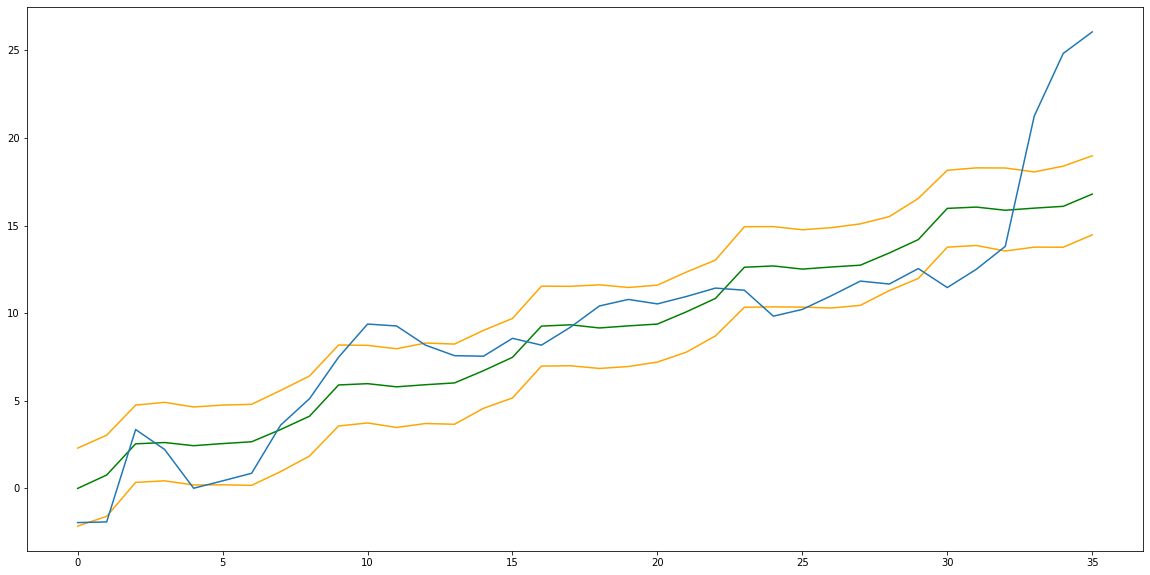

In [25]:

import pandas as pd
import numpy as np
from fbprophet import Prophet
import holidays

df_cumday_prophet = df_cumday[320:]
df_cumday_prophet = df_cumday_prophet.reset_index()

_arg3 = 7
period = _arg3+1
df = pd.DataFrame(
    {'ds': df_cumday_prophet.dates,
     'y': df_cumday_prophet.cum_nps
    })
#print(df.ds)
m = Prophet()#holidays = holidays)

m = Prophet(changepoints=['2019-09-25'])#, '2019-08-16', '2019-09-25'])'2019-09-11'

#m.add_country_holidays(country_name='ES')
df = df[:-period]
m.fit(df);
future = m.make_future_dataframe(periods=period, freq='D')
forecast = m.predict(future)
plt.plot(forecast['yhat'], c = 'green') 
plt.plot(forecast['yhat_lower'], c = 'orange') 
plt.plot(forecast['yhat_upper'], c = 'orange') 
plt.plot(df_cumday_prophet.cum_nps)


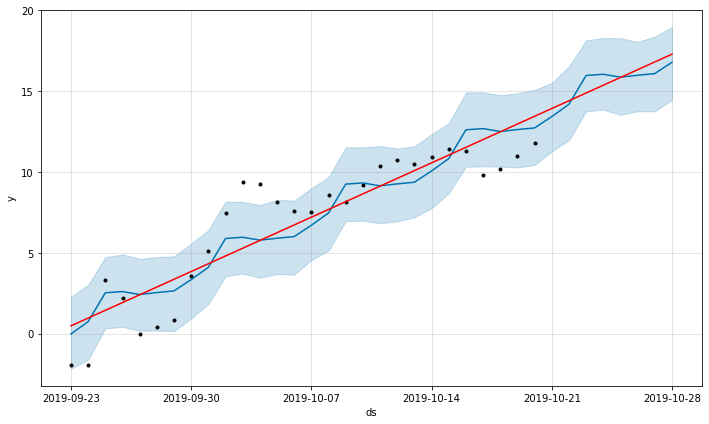

In [26]:
from fbprophet.plot import add_changepoints_to_plot
fig = m.plot(forecast)
a = add_changepoints_to_plot(fig.gca(), m, forecast)


In [27]:
forecast.tail(4)


,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,weekly,weekly_lower,weekly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
32,2019-10-25,15.856003,13.547220,18.286837,15.856003,15.856003,0.017871,0.017871,0.017871,0.017871,0.017871,0.017871,0.0,0.0,0.0,15.873874
33,2019-10-26,16.336134,13.765928,18.062055,16.336134,16.336134,-0.342230,-0.342230,-0.342230,-0.342230,-0.342230,-0.342230,0.0,0.0,0.0,15.993904
34,2019-10-27,16.816264,13.762277,18.391223,16.816264,16.816265,-0.719370,-0.719370,-0.719370,-0.719370,-0.719370,-0.719370,0.0,0.0,0.0,16.096895
35,2019-10-28,17.296395,14.465525,18.982324,17.296395,17.296395,-0.501278,-0.501278,-0.501278,-0.501278,-0.501278,-0.501278,0.0,0.0,0.0,16.795117


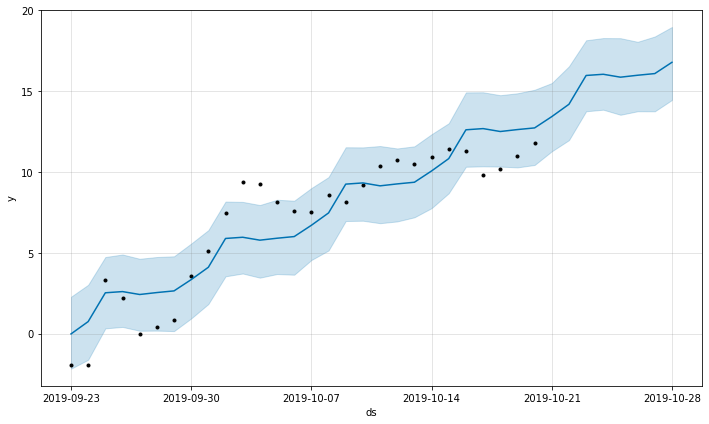

In [28]:
fig1 = m.plot(forecast)


In [29]:
future.dtypes


ds    datetime64[ns]
dtype: object

# Creating Future Dataframe
## We need a single type of data to feed the model

we create the DataFrame with pandaSQL, but each one can choose its own way.  Only need to b e same type

In [30]:

qds ="""
        SELECT date('2019-10-30') as dates UNION
        SELECT date('2019-10-31') as dates UNION
        SELECT date('2019-11-01') as dates UNION
        SELECT date('2019-11-02') as dates UNION
        SELECT date('2019-11-03') as dates UNION
        SELECT date('2019-11-04') as dates UNION
        SELECT date('2019-11-05') as dates UNION
        SELECT date('2019-11-06') as dates UNION
        SELECT date('2019-11-07') as dates UNION
        SELECT date('2019-11-08') as dates UNION
        SELECT date('2019-11-09') as dates UNION
        SELECT date('2019-11-10') as dates UNION
        SELECT date('2019-11-11') as dates UNION
        SELECT date('2019-11-12') as dates UNION
        SELECT date('2019-11-13') as dates UNION
        SELECT date('2019-11-14') as dates UNION
        SELECT date('2019-11-15') as dates UNION
        SELECT date('2019-11-16') as dates UNION
        SELECT date('2019-11-17') as dates UNION
        SELECT date('2019-11-18') as dates UNION
        SELECT date('2019-11-19') as dates UNION
        SELECT date('2019-11-20') as dates UNION
        SELECT date('2019-11-21') as dates UNION
        SELECT date('2019-11-22') as dates UNION
        SELECT date('2019-11-23') as dates UNION
        SELECT date('2019-11-24') as dates UNION
        SELECT date('2019-11-25') as dates UNION
        SELECT date('2019-11-26') as dates UNION
        SELECT date('2019-11-27') as dates UNION
        SELECT date('2019-11-28') as dates UNION
        SELECT date('2019-11-29') as dates """

#print(ps.sqldf(q1, locals()))
datesdf = ps.sqldf(qds, locals())

datesdf['dayofyear'] = pd.to_datetime(datesdf['dates']).dt.dayofyear.astype(int)
datesdf['week_'] = pd.to_datetime(datesdf['dates']).dt.week.astype(int)
datesdf['year_'] = pd.to_datetime(datesdf['dates']).dt.year.astype(int)
datesdf['month_'] = pd.to_datetime(datesdf['dates']).dt.month.astype(int)

qds ="""
        SELECT dates as ds, month_,week_,year_,year_||dayofyear as dayofyear
        from datesdf
        
        """
#print(ps.sqldf(q1, locals()))
datesdf = ps.sqldf(qds, locals())

X_predict = datesdf[['dayofyear']].copy()



In [31]:

qdvs ="""select date(ds) as ds from future union 
         select date(ds) as ds from datesdf"""

#print(ps.sqldf(q1, locals()))
lalallala = ps.sqldf(qdvs, locals())


## Save the file with predictions and thresholds

In [32]:
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].to_csv('NPS_thresholds_Nov.csv')
df_cumday_prophet.to_csv('NPS_real_NOV.csv')


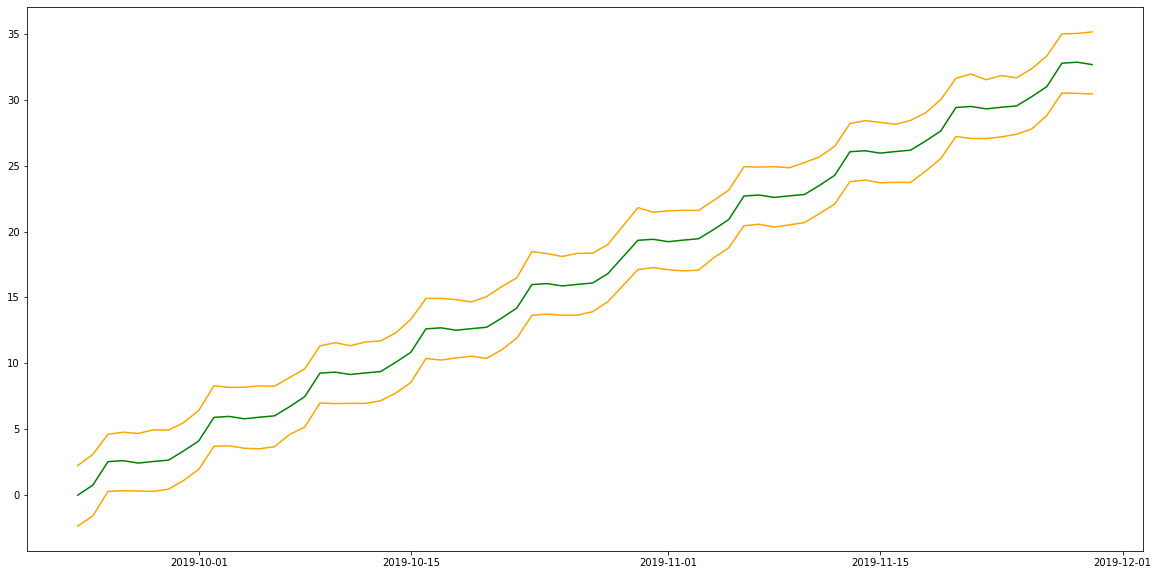

In [33]:

forecast = m.predict(lalallala)
plt.plot(forecast.ds, forecast['yhat'], c = 'green') 
plt.plot(forecast.ds, forecast['yhat_lower'], c = 'orange') 
plt.plot(forecast.ds, forecast['yhat_upper'], c = 'orange') 



INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.


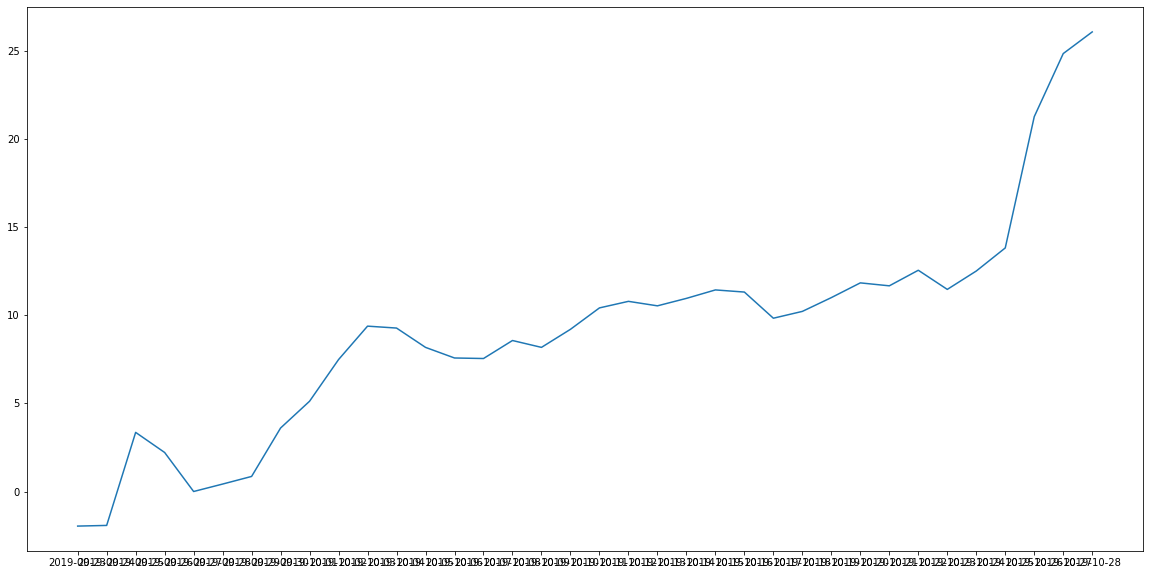

In [34]:
df_cumday_prophet
plt.plot(df_cumday_prophet.dates, df_cumday_prophet.cum_nps)


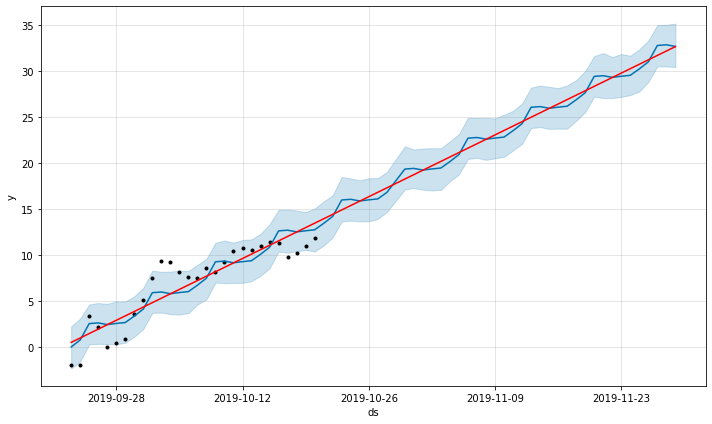

In [35]:
fig = m.plot(forecast)
a = add_changepoints_to_plot(fig.gca(), m, forecast)
